### Import Library and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn import tree
from sklearn.metrics import accuracy_score , confusion_matrix , mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn import linear_model, tree, metrics, model_selection, exceptions, ensemble, metrics
from sklearn.metrics import fbeta_score

In [2]:
data_train = pd.read_csv("Data/train_validation_dataset.csv")
data_test = pd.read_csv("Data/test_dataset.csv")

<b> Note: EDA in notebook `Data_Extraction_and_Exploratory_Data_Analysis`

### Combining train and test data for pre-processing

In [3]:
# concatenating train and test set for pre-processing
# add a column to label train and test data, where train=0, test=1.

data_train['dataset'] = 0
data_test['dataset'] = 1
data = pd.concat([data_train, data_test])
print(data.shape)

(124900, 40)


<b> Pre-processing

In [4]:
# Change date column
from datetime import datetime
date = data['date']
data['date'] = pd.to_datetime(date).dt.strftime('%m/%Y')

# replace field that's entirely space (or empty) with NaN.
data = data.replace(r'^\s*$', 'NA', regex=True)

# impute missing values NaN with 0.
data = data.replace(np.nan, 0)

In [5]:
data = data.drop(['fullvisitorid', 'Unnamed: 0'], axis=1)

<b> Transformations - Encode Categorical Data 

In [6]:
# Show Cateogrical columns using .select_dtypes()
cat_data = data.select_dtypes(include=[object]) # use this for sklearn's encoders

cat_data_cols = data.select_dtypes(
    include=[object]).columns  # use this for pd.get_dummies

print(cat_data.nunique())

date                 4
channelgrouping      8
campaign_today       5
medium_today         7
keyword_today      436
adcontent_today     24
devicecategory       3
continent            6
subcontinent        23
country            186
metro               71
city               354
operatingsystem      7
source_today         6
dtype: int64


In [7]:
data = pd.get_dummies(data, columns=cat_data_cols)

#### Split data back into train and test

- Split March-May 2017 data into Train and Validate <br>
- Jun 2017 data as Test <br>
- Perform MinMax Scaling <br>

In [8]:
# move col 'dataset' to the last col.
data = data[[c for c in data if c not in ['dataset']] + ['dataset']]
# move col 'transactions' to the last col.
data = data[[c for c in data if c not in ['transactions_target']] + ['transactions_target']]

In [9]:
train = data[data['dataset'] == 0]
test = data[data['dataset'] == 1]

<b> Split train data to train-validation

In [10]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

X = train.drop(['transactions_target', 'transactionrevenue_target'], axis=1)
y = train['transactions_target']

X_train, X_val , y_train, y_val=model_selection.train_test_split(X,y,test_size=0.3, random_state=1234)

X_train = min_max_scaler.fit_transform(X_train)
X_val = min_max_scaler.transform(X_val)

X_test = test.drop(['transactions_target', 'transactionrevenue_target'], axis=1)
y_test = test['transactions_target']

X_test = min_max_scaler.transform(X_test)

# Check train and test datasets
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(66424, 1162)
(66424,)
(28468, 1162)
(28468,)
(30008, 1162)
(30008,)


## Classification Models

The following classification models were used: <br>
- Logistic Regression
- Random Forest
- Adaptive Boosting
- Light Gradient Boosting (LGB)
- Neural Network

<b> Define optimisation scorer

In [11]:
f2_scorer = metrics.make_scorer(metrics.fbeta_score, beta = 2)

<b> Define print score function

In [12]:
def print_score(model, X_test, y_test):
    predict=model.predict(X_test)
    print("Training score is {}".format(model.score(X_train, y_train)))
    print("Validation score is {}".format(model.score(X_test, y_test)))
    print('Recall:', recall_score(y_test, predict))
    print('Precision:', precision_score(y_test, predict))
    print('Accuracy:', accuracy_score(y_test, predict))
    print("f1:", f1_score(y_test, predict))
    print("f2:", fbeta_score(y_test, predict, beta=2), '\n')
    print('Classification Score')
    print(metrics.classification_report(y_test, predict))
    print('Confusion Matrix')
    print(metrics.confusion_matrix(y_test, predict))

## 1 - Logistic Regression

<b> Parameter Tuning

In [13]:
# parameters = {'solver': ['newton-cg', 'sag','lbfgs'],
#                'C': [0.01, 0.05, 0.1, 0.2, 0.5]
#                }

# rs_lr = model_selection.RandomizedSearchCV(LogisticRegression(penalty='l2', random_state=1, class_weight='balanced'),
#                                             parameters,scoring = f2_scorer,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=5, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_lr.fit(X_train, y_train)

#results
# rs_lr.best_estimator_
# LogisticRegression(C=0.2, class_weight='balanced', dual=False,
#                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                    max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
#                    random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
#                    warm_start=False)

<b> Logistic Regression Model

In [25]:
lr = LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, 
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

lr.fit(X_train,y_train)

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

<b> Prediction with Validation Data (Logistic Regression)

In [26]:
print_score(lr, X_val, y_val)

Training score is 0.8524479103938336
Validation score is 0.8504285513559083
Recall: 0.8811513463324049
Precision: 0.1868478046859618
Accuracy: 0.8504285513559083
f1: 0.3083170890188434
f2: 0.5054863108554385 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     27391
           1       0.19      0.88      0.31      1077

    accuracy                           0.85     28468
   macro avg       0.59      0.87      0.61     28468
weighted avg       0.96      0.85      0.89     28468

Confusion Matrix
[[23261  4130]
 [  128   949]]


<b> Feature Importance (Logistic Regression)

In [54]:
lr_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': lr.coef_[0] })
print(lr_importance.sort_values('importance',ascending=False).head(10))

                                    feature  importance
2                           pageviews_today   15.356345
1                                hits_today   14.285231
3                          timeonsite_today    9.436504
19                          transactions_lt    3.872688
554                         country_Belgium    1.767657
585                         country_Ecuador    1.742471
301  keyword_today_google store merchandise    1.592827
673                     country_Puerto Rico    1.559484
32                   channelgrouping_Social    1.426745
713            country_United Arab Emirates    1.388390


In [18]:
print(lr_importance.sort_values('importance',ascending=False).tail(10))

                           feature  importance
841                    city_Boston   -0.794036
656            country_Netherlands   -0.843051
532     subcontinent_Southern Asia   -0.855802
669                   country_Peru   -0.867691
533   subcontinent_Southern Europe   -0.876445
955              city_Laguna Beach   -0.930293
670            country_Philippines   -0.937057
592                 country_France   -1.030795
44           medium_today_referral   -1.507789
1160          source_today_youtube   -1.674122


## 2 - Random Forest Modelling

<b> Parameter Tuning

In [19]:
# parameters = {'criterion': ['gini', 'entropy'],
#                'max_depth': [5, 10, 15, 20],
#                'min_samples_leaf': [1, 2],
#                'min_samples_split': [2, 4, 6],
#                'n_estimators': [10, 20, 30, 40],
#                'class_weight': ['balanced', 'balanced_subsample', None]
#                }

# rs_rf = model_selection.RandomizedSearchCV(ensemble.RandomForestClassifier(random_state=1),
#                                             parameters,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=10, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_rf.fit(X_train, y_train)
# print('best parameters: ', rs_rf.best_params_)

##results
# rs_rf.best_estimator_
# n_estimators=30, min_samples_split=6,random_state=2019,
#                                      min_samples_leaf=1, max_depth=20, criterion='entropy', class_weight='balanced'

<b> Random Forest Model

In [27]:
rf = ensemble.RandomForestClassifier(n_estimators=30, min_samples_split=6,random_state=2019,
                                     min_samples_leaf=1, max_depth=20, criterion='entropy', class_weight='balanced')


rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=30, n_jobs=None, oob_score=False,
                       random_state=2019, verbose=0, warm_start=False)

<b> Prediction with Validation Data (Random Forest)

In [28]:
print_score(rf, X_val, y_val)

Training score is 0.9362880886426593
Validation score is 0.9263383448082056
Recall: 0.8245125348189415
Precision: 0.31759656652360513
Accuracy: 0.9263383448082056
f1: 0.458559256390395
f2: 0.625 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     27391
           1       0.32      0.82      0.46      1077

    accuracy                           0.93     28468
   macro avg       0.66      0.88      0.71     28468
weighted avg       0.97      0.93      0.94     28468

Confusion Matrix
[[25483  1908]
 [  189   888]]


<b> Feature Importance for Random Forest

In [29]:
rf_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': rf.feature_importances_ })
print(rf_importance.sort_values('importance',ascending=False).head(10))

                            feature  importance
1                        hits_today    0.178941
3                  timeonsite_today    0.144316
2                   pageviews_today    0.125436
510              continent_Americas    0.042550
715           country_United States    0.041255
526   subcontinent_Northern America    0.037341
8                           hits_st    0.017710
1151   operatingsystem_b'Macintosh'    0.016335
15                          hits_lt    0.015935
1155         source_today_b'direct'    0.015321


## 3 - Adaptive Boosting

<b> Parameter Tuning

In [23]:
# parameters = {'base_estimator__criterion' : ["gini", "entropy"], 
#               'base_estimator__splitter' :   ["best", "random"],
#               'base_estimator__max_depth': [15, 20, 25, 30], 
#               'base_estimator__min_samples_split': list(range(15, 30, 5)),
#               'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1], 
#               'n_estimators': list(range(50, 200, 50))}

# DTC = tree.DecisionTreeClassifier(random_state = 2019, max_features = "auto", class_weight = "balanced")

# rs_ab = model_selection.RandomizedSearchCV(ensemble.AdaBoostClassifier(random_state = 2019, base_estimator = DTC), 
#                                   parameters, scoring = f2_scorer, 
#                                   cv = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2019),
#                                        iid=False, verbose=2, n_jobs=-1)

#rs_ab.fit(X_train, y_train)

#results
# rs_ab.best_estimator_
# AdaBoostClassifier(algorithm='SAMME',
#                    base_estimator=DecisionTreeClassifier(class_weight='balanced',
#                                                          criterion='gini',
#                                                          max_depth=25,
#                                                          max_features='auto',
#                                                          max_leaf_nodes=None,
#                                                          min_impurity_decrease=0.0,
#                                                          min_impurity_split=None,
#                                                          min_samples_leaf=1,
#                                                          min_samples_split=20,
#                                                          min_weight_fraction_leaf=0.0,
#                                                          presort=False,
#                                                          random_state=2019,
#                                                          splitter='best'),
#                    learning_rate=0.1, n_estimators=100, random_state=2019)

<b> AdaBoost Model

In [30]:
from sklearn.tree import DecisionTreeClassifier

ab= ensemble.AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=25,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=20,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2019,
                                                         splitter='best'),
                   learning_rate=0.1, n_estimators=100, random_state=2019)

ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=25,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=20,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2019,
                     

<b> Prediction with Validation Data (Adaboost)

In [31]:
print_score(ab, X_val, y_val)

Training score is 0.9447940503432495
Validation score is 0.9295349163973584
Recall: 0.8245125348189415
Precision: 0.32828096118299444
Accuracy: 0.9295349163973584
f1: 0.469592808038075
f2: 0.6331099386852987 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     27391
           1       0.33      0.82      0.47      1077

    accuracy                           0.93     28468
   macro avg       0.66      0.88      0.72     28468
weighted avg       0.97      0.93      0.94     28468

Confusion Matrix
[[25574  1817]
 [  189   888]]


<b> Feature Importance for Adaptive Boosting

In [57]:
ab_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': ab.feature_importances_ })
print(ab_importance.sort_values('importance',ascending=False).head(10))

                           feature  importance
1                       hits_today    0.135019
2                  pageviews_today    0.132302
3                 timeonsite_today    0.113976
715          country_United States    0.041932
526  subcontinent_Northern America    0.037938
510             continent_Americas    0.034758
17                   timeonsite_lt    0.017973
10                   timeonsite_st    0.016219
16                    pageviews_lt    0.015704
8                          hits_st    0.015574


## 4 - Neural Network

In [17]:
# from sklearn.neural_network import MLPClassifier
# parameters = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }

# rs_nn = model_selection.RandomizedSearchCV(MLPClassifier(random_state=2019, max_iter=100),
#                                             parameters,scoring = f2_scorer,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=5, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_nn.fit(X_train, y_train)
# rs_nn.best_estimator_

# # result
# # MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
# #               beta_2=0.999, early_stopping=False, epsilon=1e-08,
# #               hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
# #               learning_rate_init=0.001, max_iter=100, momentum=0.9,
# #               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
# #               random_state=2019, shuffle=True, solver='adam', tol=0.0001,
# #               validation_fraction=0.1, verbose=False, warm_start=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 68.4min finished
C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [18]:
from sklearn.neural_network import MLPClassifier

nn= MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

nn.fit(X_train, y_train)

C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

<b> Prediction with Validation Data (Neural Network)

In [19]:
print_score(nn, X_val, y_val)

Training score is 0.9765596772250994
Validation score is 0.9641702964732332
Recall: 0.37604456824512533
Precision: 0.5378486055776892
Accuracy: 0.9641702964732332
f1: 0.4426229508196721
f2: 0.40011855364552457 

Classification Score
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     27391
           1       0.54      0.38      0.44      1077

    accuracy                           0.96     28468
   macro avg       0.76      0.68      0.71     28468
weighted avg       0.96      0.96      0.96     28468

Confusion Matrix
[[27043   348]
 [  672   405]]


## 5 - LightGBM

In [32]:
import lightgbm as lgb

<b> Parameter Tuning

In [30]:
# coarse to fine tuning
# parameter tuning guideline from: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# Step 1 - coarse
# parameters = {'num_leaves': [10,20,30,40,50], 'min_data_in_leaf': [5, 10, 20, 30, 50, 100],'max_depth': [-1, 20, 40, 60, 100]}

# lgb_fit = model_selection.RandomizedSearchCV(lgb.LGBMClassifier(), parameters, scoring =  f2_scorer,
#                                    cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2019))
    
# lgb_fit.fit(X_train, y_train)
# print('best score:', lgb_fit.best_score_)
# print('best parameters: ', lgb_fit.best_params_)

# #results
# #best score: 0.4311396027489838
# #best parameters:  {'num_leaves': 50, 'min_data_in_leaf': 20, 'max_depth': 100}

# Step 2 - fine
# parameters = {'num_leaves': [30,50,70,90], 'min_data_in_leaf': [10,20,30,40],'max_depth': [100,120,140,160]}

# lgb_fit = model_selection.RandomizedSearchCV(lgb.LGBMClassifier(), parameters, scoring =  f2_scorer,
#                                    cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2019))
    
# lgb_fit.fit(X_train, y_train)
# print('best score:', lgb_fit.best_score_)
# print('best parameters: ', lgb_fit.best_params_)
# best score: 0.42790358761961755
# best parameters:  {'num_leaves': 90, 'min_data_in_leaf': 10, 'max_depth': 160}

# Note: to use step 1 tuning as it generate better score

<b> Light Gradient Boosting Model

In [33]:
lgb_c = lgb.LGBMClassifier(learning_rate = 0.04, n_estimators = 3200, boosting_type = 'dart', num_leaves = 50, min_data_in_leaf = 20, max_depth = 100)
lgb_c.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          eval_metric = None,
          verbose = 500)

[500]	valid_0's binary_logloss: 0.07955
[1000]	valid_0's binary_logloss: 0.0787081
[1500]	valid_0's binary_logloss: 0.0788506
[2000]	valid_0's binary_logloss: 0.0797679
[2500]	valid_0's binary_logloss: 0.0813829
[3000]	valid_0's binary_logloss: 0.0829726


LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.04, max_depth=100,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=20, min_split_gain=0.0, n_estimators=3200,
               n_jobs=-1, num_leaves=50, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

<b> Prediction with Validation Data (LGB) 

In [34]:
print_score(lgb_c, X_val, y_val)

Training score is 0.9942490666024328
Validation score is 0.9690880989180835
Recall: 0.44661095636026
Precision: 0.6287581699346405
Accuracy: 0.9690880989180835
f1: 0.5222584147665581
f2: 0.4740784545633747 

Classification Score
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     27391
           1       0.63      0.45      0.52      1077

    accuracy                           0.97     28468
   macro avg       0.80      0.72      0.75     28468
weighted avg       0.97      0.97      0.97     28468

Confusion Matrix
[[27107   284]
 [  596   481]]


In [56]:
lgb_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': lgb_c.feature_importances_ })
print(lgb_importance.sort_values('importance',ascending=False).head(10))

                           feature  importance
3                 timeonsite_today       34290
1                       hits_today       17570
2                  pageviews_today       17111
17                   timeonsite_lt        6308
10                   timeonsite_st        6071
15                         hits_lt        3402
8                          hits_st        3145
1151  operatingsystem_b'Macintosh'        2990
9                     pageviews_st        2828
21                    date_03/2017        2795


### Precision Recall Chart - Validation Data

In [38]:
lr_proba_val=lr.predict_proba(X_val)[:, 1]
rf_proba_val=rf.predict_proba(X_val)[:, 1]
ab_proba_val=ab.predict_proba(X_val)[:, 1]
nn_proba_val=nn.predict_proba(X_val)[:, 1]
lgb_proba_val=lgb_c.predict_proba(X_val, num_iteration=lgb_c.best_iteration_)[:,1]

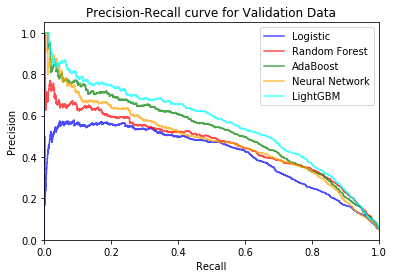

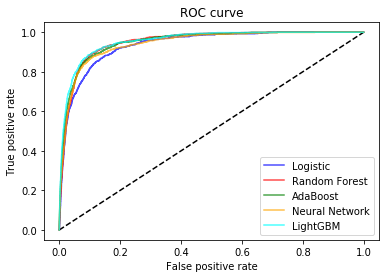

In [39]:
from inspect import signature

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_val, lr_proba_val)
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_val, rf_proba_val)
ab_precision, ab_recall, _ = metrics.precision_recall_curve(y_val, ab_proba_val)
nn_precision, nn_recall, _ = metrics.precision_recall_curve(y_val, nn_proba_val)
lgb_precision, lgb_recall, _ = metrics.precision_recall_curve(y_val, lgb_proba_val)

step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
plt.step(lr_recall, lr_precision, color='blue', alpha=0.7, where='post', label='Logistic')
plt.step(rf_recall, rf_precision, color='red', alpha=0.7, where='post', label='Random Forest')
plt.step(ab_recall, ab_precision, color='green', alpha=0.7, where='post', label='AdaBoost')
plt.step(nn_recall, nn_precision, color='orange', alpha=0.7, where='post', label='Neural Network')
plt.step(lgb_recall, lgb_precision, color='cyan', alpha=0.7, where='post', label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Validation Data')
plt.legend(loc='best')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_val, lr_proba_val)
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_proba_val)
fpr_ab, tpr_ab, _ = roc_curve(y_val, ab_proba_val)
fpr_nn, tpr_nn, _ = roc_curve(y_val, nn_proba_val)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, lgb_proba_val)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic',color='blue', alpha=0.7)
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color='red', alpha=0.7)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost',color='green', alpha=0.7)
plt.plot(fpr_nn, tpr_nn, label='Neural Network',color='orange', alpha=0.7)
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM',color='cyan', alpha=0.7)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Model Comparison - Test Data

<b> 1. Prediction with Test Data (Logistic Regression)

In [40]:
print ('Logistic Regression')
print_score(lr, X_test, y_test)

Logistic Regression
Training score is 0.8524479103938336
Validation score is 0.8351439616102373
Recall: 0.8785834738617201
Precision: 0.17827202737382378
Accuracy: 0.8351439616102373
f1: 0.29640164983643863
f2: 0.49202002077627727 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.83      0.91     28822
           1       0.18      0.88      0.30      1186

    accuracy                           0.84     30008
   macro avg       0.59      0.86      0.60     30008
weighted avg       0.96      0.84      0.88     30008

Confusion Matrix
[[24019  4803]
 [  144  1042]]


<b> 2. Prediction with Test Data (Random Forest)

In [41]:
print ('Random Forest')
print_score(rf, X_test, y_test)

Random Forest
Training score is 0.9362880886426593
Validation score is 0.9189216209010931
Recall: 0.8195615514333895
Precision: 0.3046067063616421
Accuracy: 0.9189216209010931
f1: 0.44413982179575046
f2: 0.612476370510397 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     28822
           1       0.30      0.82      0.44      1186

    accuracy                           0.92     30008
   macro avg       0.65      0.87      0.70     30008
weighted avg       0.96      0.92      0.94     30008

Confusion Matrix
[[26603  2219]
 [  214   972]]


<b> 3. Prediction with Test Data (Adaboost)

In [42]:
print_score(ab, X_test, y_test)

Training score is 0.9447940503432495
Validation score is 0.9229872034124234
Recall: 0.7967959527824621
Precision: 0.31343283582089554
Accuracy: 0.9229872034124234
f1: 0.44989288264698885
f2: 0.6089702281221807 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     28822
           1       0.31      0.80      0.45      1186

    accuracy                           0.92     30008
   macro avg       0.65      0.86      0.70     30008
weighted avg       0.96      0.92      0.94     30008

Confusion Matrix
[[26752  2070]
 [  241   945]]


<b> 4. Prediction with Test Data (Neural Network)

In [43]:
print_score(nn, X_test, y_test)

Training score is 0.9765596772250994
Validation score is 0.9616768861636897
Recall: 0.3785834738617201
Precision: 0.5208816705336426
Accuracy: 0.9616768861636897
f1: 0.43847656249999994
f2: 0.40046378879771677 

Classification Score
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28822
           1       0.52      0.38      0.44      1186

    accuracy                           0.96     30008
   macro avg       0.75      0.68      0.71     30008
weighted avg       0.96      0.96      0.96     30008

Confusion Matrix
[[28409   413]
 [  737   449]]


<b> 5. Prediction with Validation Data (Light Gradient Boosting)

In [44]:
print_score(lgb_c, X_test, y_test)

Training score is 0.9942490666024328
Validation score is 0.9649426819514796
Recall: 0.3768971332209106
Precision: 0.5881578947368421
Accuracy: 0.9649426819514796
f1: 0.4594039054470709
f2: 0.40606831395348836 

Classification Score
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28822
           1       0.59      0.38      0.46      1186

    accuracy                           0.96     30008
   macro avg       0.78      0.68      0.72     30008
weighted avg       0.96      0.96      0.96     30008

Confusion Matrix
[[28509   313]
 [  739   447]]


### Precision Recall Chart - Test Data

In [45]:
lr_proba_test=lr.predict_proba(X_test)[:, 1]
rf_proba_test=rf.predict_proba(X_test)[:, 1]
ab_proba_test=ab.predict_proba(X_test)[:, 1]
nn_proba_test=nn.predict_proba(X_test)[:, 1]
lgb_proba_test=lgb_c.predict_proba(X_test, num_iteration=lgb_c.best_iteration_)[:,1]

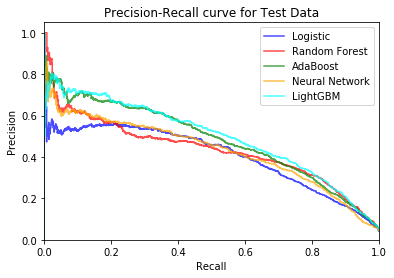

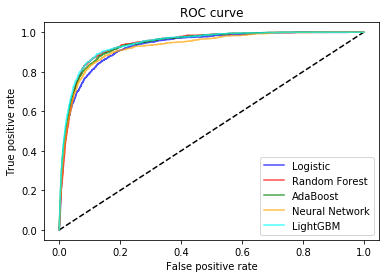

In [46]:
from inspect import signature

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, lr_proba_test)
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_test, rf_proba_test)
ab_precision, ab_recall, _ = metrics.precision_recall_curve(y_test, ab_proba_test)
nn_precision, nn_recall, _ = metrics.precision_recall_curve(y_test, nn_proba_test)
lgb_precision, lgb_recall, _ = metrics.precision_recall_curve(y_test, lgb_proba_test)

step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
plt.step(lr_recall, lr_precision, color='blue', alpha=0.7, where='post', label='Logistic')
plt.step(rf_recall, rf_precision, color='red', alpha=0.7, where='post', label='Random Forest')
plt.step(ab_recall, ab_precision, color='green', alpha=0.7, where='post', label='AdaBoost')
plt.step(nn_recall, nn_precision, color='orange', alpha=0.7, where='post', label='Neural Network')
plt.step(lgb_recall, lgb_precision, color='cyan', alpha=0.7, where='post', label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Test Data')
plt.legend(loc='best')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba_test)
fpr_ab, tpr_ab, _ = roc_curve(y_test, ab_proba_test)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_proba_test)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_proba_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic',color='blue', alpha=0.7)
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color='red', alpha=0.7)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost',color='green', alpha=0.7)
plt.plot(fpr_nn, tpr_nn, label='Neural Network',color='orange', alpha=0.7)
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM',color='cyan', alpha=0.7)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Threshold Curves - Test Data

In [47]:
def plot_prec_recall_vs_tresh(y_test, proba):
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, proba)
    
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.xlim([0,1.05])
    plt.ylim([0,1.05])

<b> Logistic Regression

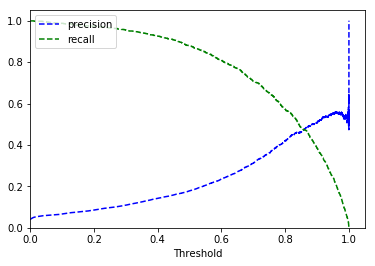

In [48]:
plot_prec_recall_vs_tresh(y_test, lr_proba_test)
plt.show()

<b> Random Forest

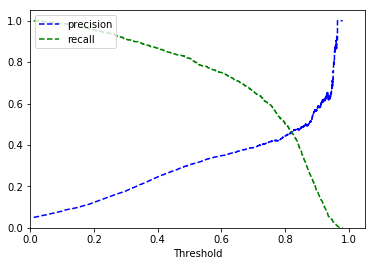

In [49]:
plot_prec_recall_vs_tresh(y_test, rf_proba_test)
plt.show()

<b> Adaptive Boosting

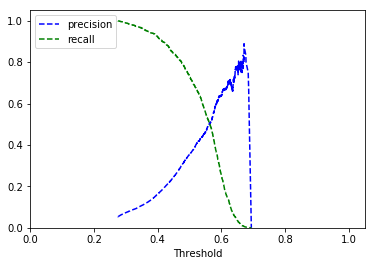

In [50]:
plot_prec_recall_vs_tresh(y_test, ab_proba_test)
plt.show()

<b> Neural Network

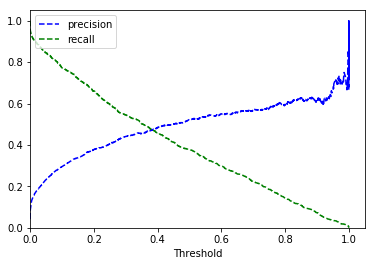

In [51]:
plot_prec_recall_vs_tresh(y_test, nn_proba_test)
plt.show()

<b> Light GBM

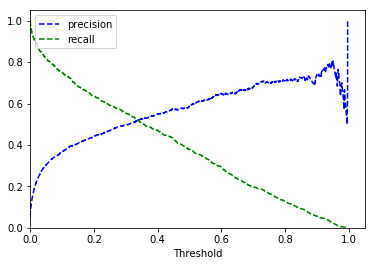

In [52]:
plot_prec_recall_vs_tresh(y_test, lgb_proba_test)
plt.show()

### Exporting Results

<b> Feature Importance

In [58]:
lr_importance.to_csv('Feature_Importance_02_LR.csv')
rf_importance.to_csv('Feature_Importance_02_RF.csv')
ab_importance.to_csv('Feature_Importance_02_AB.csv')
lgb_importance.to_csv('Feature_Importance_02_LGB.csv')

<b> Results

In [59]:
combine_proba=pd.concat([pd.DataFrame(lr_proba_test, columns=['Logistic_Regression']).reset_index(),
                         pd.DataFrame(rf_proba_test, columns=['Random_Forest']).reset_index(),
                         pd.DataFrame(ab_proba_test, columns=['AdaBoost']).reset_index(),
                         pd.DataFrame(nn_proba_test, columns=['Neural_Network']).reset_index(),
                         pd.DataFrame(lgb_proba_test, columns=['Light_GBM']).reset_index()
                        ], axis=1).drop('index', axis=1)

In [60]:
combine_with_data=pd.concat([pd.DataFrame(X_test, columns=X.columns).reset_index(), 
                             pd.DataFrame(y_test).reset_index(), 
                             combine_proba.reset_index()], axis=1).drop('index', axis=1)

In [61]:
combine_with_data.head(10)

,sessions,hits_today,pageviews_today,timeonsite_today,bounces_today,newvisits_today,ismobile,visits_st,hits_st,pageviews_st,...,source_today_b'others',source_today_b'partners',source_today_b'youtube',dataset,transactions_target,Logistic_Regression,Random_Forest,AdaBoost,Neural_Network,Light_GBM
0,0.0,0.0,0.004292,0.122858,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.265618,0.182679,0.319171,1.743440e-04,0.000191
1,0.0,0.0,0.004292,0.001648,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.000573,0.016216,0.268941,1.366359e-08,0.000003
2,0.0,0.0,0.004292,0.000577,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.072564,0.074224,0.283780,3.705245e-05,0.000148
3,0.0,0.0,0.004292,0.001071,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.053361,0.018814,0.271910,1.607968e-05,0.000234
4,0.0,0.0,0.004292,0.006427,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0,0.048542,0.051542,0.295558,2.090922e-04,0.000155
5,0.0,0.0,0.004292,0.000082,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.011057,0.005107,0.270479,9.618196e-08,0.000015
6,0.0,0.0,0.004292,0.003790,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.484860,0.120113,0.316700,1.433219e-03,0.002265
7,0.0,0.0,0.004292,0.001401,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.072206,0.050741,0.282384,4.718057e-05,0.000015
8,0.0,0.0,0.004292,0.015903,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.549489,0.370340,0.416841,1.220718e-02,0.013730
9,0.0,0.0,0.004292,0.001401,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.450620,0.248650,0.447769,3.897642e-02,0.013642


In [62]:
combine_with_data.to_csv('Result_02_No_FE.csv')

<b> Save Model

In [63]:
import pickle

with open('LR_02.pkl', 'wb') as file:  
    pickle.dump(lr, file)
    
with open('RF_02.pkl', 'wb') as file:  
    pickle.dump(rf, file)
    
with open('AB_02.pkl', 'wb') as file:  
    pickle.dump(ab, file)
    
with open('NN_02.pkl', 'wb') as file:  
    pickle.dump(ab, file)

with open('LightGBM_02.pkl', 'wb') as file:  
    pickle.dump(lgb_c, file)

## Anomaly Detection 

#### Data Preparation

<b> Reconfigure X_train and X_test for Anomaly detection </b><br>
concat X_train and y_train -> this is for fit <br>
slice out only the values for 'transasction_target==0' -> this is for predict <br>
concat X_test and y_test -> this is for validation <br>

In [16]:
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import IsolationForest

min_max_scaler2 = preprocessing.MinMaxScaler()

train_w_label = pd.concat([X, y], axis=1)

#only keep the majority class
train_anomaly = train_w_label.loc[train_w_label['transactions_target'] == 0].drop('transactions_target', axis=1)
X_train_anomaly = min_max_scaler2.fit_transform(train_outlier)

#get the validation x and y
X_val_anomaly = min_max_scaler2.transform(train_w_label.drop('transactions_target', axis=1))
y_val_anomaly = train_w_label['transactions_target']

test_w_label=pd.concat([pd.DataFrame(X_test, columns=X.columns), y_test], axis=1)
X_test_anomaly=min_max_scaler2.transform(test_w_label.drop('transactions_target', axis=1))
y_test_anomaly=test_w_label['transactions_target']

<b> Print Score function for Anomaly Detection 

In [17]:
def print_score_anomaly (y_test, predict):
    print('Recall:', recall_score(y_test, predict))
    print('Precision:', precision_score(y_test, predict))
    print('Accuracy:', accuracy_score(y_test, predict))
    print("f1:", f1_score(y_test, predict))
    print("f2:", fbeta_score(y_test, predict, beta=2), '\n')
    print('Classification Score')
    print(metrics.classification_report(y_test, predict))
    print('Confusion Matrix')
    print(metrics.confusion_matrix(y_test, predict))

## 6 - OneClassSVM

In [ ]:
oneclass = svm.OneClassSVM(kernel='rbf', nu=0.0388, gamma=0.01, verbose=2)
oneclass.fit(X_train_anomaly)

In [ ]:
oneclass_pred = oneclass.predict(X_test_anomaly)
unique, counts = np.unique(oneclass_pred, return_counts=True)
print (np.asarray((unique, counts)).T)
oneclass_pred=pd.DataFrame(oneclass_pred).replace(1,0).replace(-1,1).values.tolist()

<b> Prediction with Test Data (One Class SVM) 

In [ ]:
print_score_anomaly(y_test_anomaly, oneclass_pred)

## 7 - Isolation Forest

In [18]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), 
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

iforest.fit(X_train_anomaly)

C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.12,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=42, verbose=0, warm_start=False)

In [20]:
iforest_pred = iforest.predict(X_test_anomaly)
unique, counts = np.unique(iforest_pred, return_counts=True)
print (np.asarray((unique, counts)).T)
iforest_pred=pd.DataFrame(iforest_pred).replace(1,0).replace(-1,1).values.tolist()

C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


[[   -1  2704]
 [    1 27304]]


<b> Prediction with Test Data (Isolation Forest) 

In [21]:
print_score_anomaly(y_test_anomaly, iforest_pred)

Recall: 0.05227655986509275
Precision: 0.022928994082840236
Accuracy: 0.8745001332977873
f1: 0.03187660668380462
f2: 0.041621911922663804 

Classification Score
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     28822
           1       0.02      0.05      0.03      1186

    accuracy                           0.87     30008
   macro avg       0.49      0.48      0.48     30008
weighted avg       0.92      0.87      0.90     30008

Confusion Matrix
[[26180  2642]
 [ 1124    62]]


<b> Save Models

In [ ]:
import pickle

with open('OneSVM_02.pkl', 'wb') as file:  
    pickle.dump(oneclass, file)
    
with open('iForest_02.pkl', 'wb') as file:  
    pickle.dump(iforest, file)
